# Customer Segmentation of Arvato-Bertelsmann customers

The Arvato-Group is one of total 8 business units in the Bertelsmann Group which is a worldwide operating service company head-quarted in Germany.<br>
The main operating field of Avarto are logistics- and supply chain services and solutions, financial services as well as the operation of IT Systems. Concerning the general figures to get a grasp of the company, the company employs a staff around 77.342 persons (2020) and generates a sales volume of 5.56 Mrd. EUR per anno (2024).

The present project can be localized in the financial services branch of Arvato (Arvato Financial Solutions).<br><br>
<span style="color: green;">**One client of Arvato Financial Solutions, a Mail-Order Company selling organic products, wants to be advised concerning a more efficient way to acquire new clients.<br>
In essence, the company wants their acquisition marketing campaings instead of reaching out to everyone (costly), target more precisely those persons which show the highest probability to turn into new customers.**</span>
<br><br>
<span style="text-decoration: underline;">The project spans two main tasks:</span>
1) Customer Segmentation: An Analysis of the existing customer database dataset is carried out and on this basis a general recommandation of which people in Germany are most likely to be new customers of the company is generated. <br><br>
2) Modelling Campaign-Responses: Using the results of 1) to build a machine learning model that predicts whether or not an individual will respond to the respective campaign.

This notebook focuses after the EDA section on the first main task.




## I. Methodology

Concerning the methodology, the procedure consists of the following steps:

<img src = '../data/img/procedure_segmentation.PNG'/>

1) In the first step (step 0 above), the datasets (Azdias Dataset and the customers dataset) is after the extensive EDA prepared and cleaned for the further steps. This step contains replacing unknown values, handling missing values, dropping specific (not important) columns, handling high correlation columns, feature engineering, imputing, feature encoding etc.  
2) Next, Principal Component Analysis is used to reduce the number of columns without loosing a big stake of the information
3) With these Components expressing the main information of the data in a reduced form, KMeans Cluster Algorithm is applied to find the optimal number of clusters for the dataset (without the risk to fail for the curse of dimensionality)
4) The last two steps are applied either to the cleaned customers dataset 
5) And in the last step, we compare the clusters in the two datasets to determine the cluster of customers which are of high importance for the company

## II. Data Preparation

### Import relevant libraries and load the data

In [52]:
#Import relevant libraries
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 999)
pd.set_option('display.max_colwidth', None)

import os
import re

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import seaborn as sns

import seaborn as sns

from scipy.stats import skew, kurtosis

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from scipy import stats

%matplotlib inline

Load data

In [53]:
root_path = os.path.dirname(os.getcwd())

azdias = pd.read_csv(rf'{root_path}\data\customer_segmentation\Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)
customers = pd.read_csv(rf'{root_path}\data\customer_segmentation\Udacity_CUSTOMERS_052018.csv', sep=';', low_memory=False)

feature_summary = pd.read_excel(rf'{root_path}\data\description\DIAS Attributes - Values 2017.xlsx')

### Data Preparation

In the following part, the data is step by step prepared for the Principal Component Analysis:

In [54]:
print(f"azdias shape: {azdias.shape}")
print(f"customers shape: {customers.shape}")
print(f"feature_summary shape: {feature_summary.shape}")

azdias shape: (891221, 366)
customers shape: (191652, 369)
feature_summary shape: (2258, 5)


**The preprocessing steps follow the following logic:**
* unknown values are first of all replaced in the two dataframe with np.nan to get the datasets in a consistent form
* As the datasets contain several missing values, the function handle_missing_values is used to drop all rows which contain more than 250 missing values and all columns which show a missing value proportion of more than 50 %
* After that several columns are dropped which can be considered as informative for our problem. Either determined by logical deduction or particularly low variance and therefore no information content for the problem
* With the function "feat_eng_jugendjahre", the years in which the respective individual spend his youth years and the movement of the individual is extracted from a string value per row
* As there are even with missing value handling a significant number of missing values in the dataset, the data is imputed by a really simple strategy (most frequent) 
* Concerning the categorical values, the values of these columns have to be encoded because PCA doesn't interpret categorical values. We are using One-Hot-Encoding for the encoding step
* To finish the preprocessing phase, we standardize the data to reduce the potential dominance of certain features with a high range within PCA

In [55]:
def replace_unknown_values(df_, ds_name):
    """Replace unknown values with the data with np.nan

    Args:
        df_ (pandas.DataFrame): DataFrame to replace in
        ds_name (str): Name of the dataset

    Returns:
        pandas.DataFrame: DataFrame with replace unknown values
    """
    df_ = df_.copy()

    ############### treat unknown values as missing ###############
    mapping = {}

    feat_unknown = feature_summary[feature_summary["Meaning"] == "unknown"]

    for col in feat_unknown["Attribute"].unique():
        ls = feat_unknown[feat_unknown["Attribute"] == col]["Value"].values.tolist()

        if isinstance(ls[0], str):
            mapping[col] = [int(element) for element in ls[0].split(",")]
        else:
            mapping[col] = ls

    for col in df_.columns:
        if col in list(mapping.keys()):
            df_[col] = np.where(df_[col].isin(mapping[col]), np.nan, df_[col])  

    df_ = df_.replace(["XX", "X"], np.nan)

    print(f"Unknown data for dataset {ds_name} has been replaced with nan-vals.\n")

    return df_

def handle_missing_values(df_, row_threshold = 250, col_threshold = 0.5, relevant_cols = []):
    """Determine the rows which show more than a given number of columns with missing values and columns which contains above a given
       percentage of missing values to drop these elements.

    Args:
        df_ (pandas.DataFrame): Input DataFrame
        row_threshold (int, optional): Threshold number of columns with missing values. Exceeding the threshold means to drop the respective row. Defaults to 250.
        col_threshold (float, optional): Threshold percentage of missing values per columns. Exceeding the threshold means to drop the respective feature. Defaults to 0.5.
        relevant_cols (list, optional): For the customers-set the columns determined by the azdias set will be dropped. Defaults to [].

    Returns:
        pandas.DataFrame, list = clean DataFrame, list of relevant columns
    """

    df_ = df_.copy()

    #Handle row-wise missing values
    print("---Handle row-wise missing values---")
    print(f"Shape of dataframe before processing {df_.shape}")
    rows_to_drop = df_[df_.isnull().sum(axis = 1)>row_threshold].index.tolist()
    df_ = df_.drop(rows_to_drop, axis = 0)
    print(f"Shape of dataframe after processing {df_.shape}")

    #Handle column-wise missing values / choose relevant columns concern. missing values
    print("---Handle columns-wise missing values---")    
    if len(relevant_cols)>0:
        df_ = df_[relevant_cols].copy()
        print("The provided columns {relevant_cols} have been dropped.")
        return df_
    
    else:
        cols_to_drop = df_.isnull().mean()[df_.isnull().mean()>col_threshold].index
        df_ = df_.drop(cols_to_drop, axis = 1)
        print("The following columns {relevant_cols} have been dropped.")

        return df_, df_.columns
    
def drop_specific_cols(df_, columns, ds_name):
    """Drop provided columns 

    Args:
        df_ (pandas.DataFrame): Input df
        columns (list): columns to drop
        ds_name (str): Name of the dataset 

    Returns:
        pandas.DataFrame: output df without the provided columns
    """
    print(f"The shape of the dataset {ds_name} before processing: {df_.shape}")

    try:
        df_.drop(columns, axis = 1, inplace = True)
        print(f"The shape of the dataset {ds_name} after processing: {df_.shape}")
    except:    
        print(f"No processing.")

    return df_

def feat_eng_jugendjahre(df_, ds_name, feature_summary):
    """Extract the movement and the year an individual passed his youth years out of the Feature "PRAEGENDE_JUGENDJAHRE" 

    Args:
        df_ (pandas.DataFrame): Input df
        ds_name (str): _description_
        feature_summary (pandas.DataFrame): Masterdata / Description of the data provided by Arvato to build a mapping function for the columns 
    """

    def extract_movement(txt):
        """Extract the movement from the Attribute PRAEGENDE_JUGENDJAHRE	

        Args:
            txt (str): text value of the attribute PRAEGENDE_JUGENDJAHRE	

        Returns:
            str: if extraction works out: movement type, else: input value
        """

        try:

            start_ = re.search(r"\(", txt).start()
            end_ = re.search(r"\)", txt).start() + 1

            return_txt = txt[start_: end_]
            txt_ls = return_txt.split(",")

            return txt_ls[0][1:]
        except:
            
            return txt

    def get_mapping(feature):
        """Function to provide a feature mapping from feature values to meaning of these values

        Args:
            feature (str): Feature to provide a mapping for

        Raises:
            LookupError: if a feature is not found in the feature_summary dataframe. This error is raised to inform the user of the non-existence

        Returns:
            dict: Dictionary with the mapping feature_value:meaning 
        """

        if feature in feature_summary["Attribute"].unique().tolist():
            mapping_ = feature_summary[feature_summary["Attribute"] == feature][["Value", "Meaning"]].set_index("Value").to_dict()["Meaning"]
        else:
            raise LookupError("Can't find the provided feature in data.")

        return mapping_

    df_pj = df_["PRAEGENDE_JUGENDJAHRE"].copy().to_frame()
    df_pj["praegende_jugendjahre_cat"] = df_["PRAEGENDE_JUGENDJAHRE"].map(get_mapping("PRAEGENDE_JUGENDJAHRE"))

    df_pj["youth_years"] = df_pj["praegende_jugendjahre_cat"].apply(lambda x: str(x)[:2])
    df_pj["movement_type"] = df_pj["praegende_jugendjahre_cat"].str[:].apply(lambda x: extract_movement(x))

    df_.drop("PRAEGENDE_JUGENDJAHRE", axis = 1, inplace = True)
    df_ = pd.concat([df_, df_pj], axis = 1)

    df_.drop("praegende_jugendjahre_cat", axis = 1, inplace = True)
    df_.drop("PRAEGENDE_JUGENDJAHRE", axis = 1, inplace = True)

    print(f"Feature Engineering 'Praegende Jugendjahre' for dataset {ds_name} executed.")

    return df_

def create_correlation_report(df, corr_threshold = 0.7, untouchable_feats = []):
    """Check the bi-variate correlation in the dataframe and create a list with selected features.
       If a feature-pair shows high correlation, the feature with fewer nan-vals is kept.  

    Inputs:
        df(pandas.DataFrame): Input dataframe
        corr_threshold(float): threshold for the correlation to be defined as high correlated

    Returns:
        list, dict: 
    """
    processed_cols = [] #already processed or dropped before
    processed_cols.extend(untouchable_feats)

    selected_cols = [] #selected features
    selected_cols.extend(untouchable_feats)

    high_corr_dict = {} #dictionary for each selected col with the highly correlated (and dropped features)
    nan_matrix = df.isnull().sum().sort_values().reset_index()
    corr_df = df.select_dtypes(exclude=["object"]).corr()

    #looping through the columns of correlation_df
    for col in corr_df.columns:

        if col not in processed_cols:
            
            processed_cols.append(col)
            corr_ls = []
            nan_rank_col = nan_matrix[nan_matrix["index"] == col].index.item()
            selected = True

            for counterpart in corr_df[col].index.tolist():

                if (counterpart not in selected_cols) & (counterpart != col) & (counterpart not in processed_cols):
                    corr_ = corr_df[col].loc[counterpart].item()

                    if abs(corr_) > corr_threshold:
                        
                        if nan_rank_col < nan_matrix[nan_matrix["index"] == counterpart].index.item():
                            corr_ls.append([counterpart, corr_])
                            processed_cols.append(counterpart)
                        else:
                            selected = False
                            break
            
            if selected == True:
                selected_cols.append(col)
                high_corr_dict[col] = corr_ls
        
    return selected_cols, high_corr_dict

def impute_values(df_, ds_name, imputer = None):
    """Impute the missing values with a simple imputing function

    Args:
        df_ (pandas.DataFrame): input df
        ds_name (str): Name of the dataset

    Returns:
        pd.DataFrame: imputed DataFrame
    """

    df_dtypes = {feat: str(df_.dtypes.loc[feat]) for feat in df_.dtypes.index}

    if imputer is None:
        imputer = SimpleImputer(strategy="most_frequent")
        df_ = pd.DataFrame(data = imputer.fit_transform(df_), columns = df_.columns)

        for col in list(df_dtypes.keys()):
            df_[col] = df_[col].astype(df_dtypes[col])

        print(f"Dataset {ds_name} has been imputed.\n")

        return df_, imputer
    else:
        df_ = pd.DataFrame(data = imputer.transform(df_), columns = df_.columns)

        for col in list(df_dtypes.keys()):
            df_[col] = df_[col].astype(df_dtypes[col])

        print(f"Dataset {ds_name} has been imputed.\n")

        return df_
    
def encode_categorical_feats(df_, ds_name, feats_to_encode = []):
    """Encode the categorical feature

    Args:
        df_ (pandas.DataFrame): Input df
        ds_name (str): Name of the dataset
        feats_to_encode (list, optional): Features to encode for the test set (Collected in the train set). Defaults to [].

    Returns:
        _type_: _description_
    """

    df_encoded = df_.copy()
    encoded = False

    if len(feats_to_encode) == 0:
        feats_to_encode = df_encoded.select_dtypes(include = ["object"]).columns.tolist()
        encoded = True
    
    df_encoded = pd.get_dummies(df_encoded, columns = feats_to_encode, drop_first = True)

    df_encoded = df_encoded.astype("int")

    print(f"Categorical features of dataset {ds_name} encoded.")

    if encoded:
        return df_encoded, feats_to_encode
    else:
        return df_encoded
    
def standardize(df_, scaler = None):
    """Standardizing the data

    Args:
        df_ (pandas.DataFrame): Input df
        scaler (StandardScaler, optional): Fitted Scaler on train set to apply on test set. Defaults to None.

    Returns:
        _type_: _description_
    """
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(df_)
        df_ = pd.DataFrame(
            data = scaler.transform(df_),
            columns = df_.columns
        )
        return df_, scaler
    else:
        df_ = pd.DataFrame(
            data = scaler.transform(df_),
            columns = df_.columns 
        )

        return df_

In [56]:
azdias_copy = replace_unknown_values(azdias, ds_name = "Azdias")
customers_copy = replace_unknown_values(customers, ds_name = "customers")

Unknown data for dataset Azdias has been replaced with nan-vals.

Unknown data for dataset customers has been replaced with nan-vals.



In [57]:
azdias_copy, relevant_columns = handle_missing_values(azdias_copy, row_threshold=250, col_threshold=0.5)
customers_copy = handle_missing_values(customers, row_threshold=250, col_threshold=0.5, relevant_cols=relevant_columns)

---Handle row-wise missing values---
Shape of dataframe before processing (891221, 366)
Shape of dataframe after processing (817684, 366)
---Handle columns-wise missing values---
The following columns {relevant_cols} have been dropped.
---Handle row-wise missing values---
Shape of dataframe before processing (191652, 369)
Shape of dataframe after processing (145052, 369)
---Handle columns-wise missing values---
The provided columns {relevant_cols} have been dropped.


In [58]:
#check if the columns in azdias / customers are identical
set(azdias_copy.columns) == set(customers_copy.columns)

True

In [59]:
non_informative_feats = ["LNR", "EINGEFUEGT_AM", "EINGEZOGENAM_HH_JAHR", "NATIONALITAET_KZ"]

azdias_copy = drop_specific_cols(df_ = azdias_copy, columns = non_informative_feats, ds_name = "Azdias")
customers_copy = drop_specific_cols(df_ = customers_copy, columns = non_informative_feats, ds_name = "customers")

The shape of the dataset Azdias before processing: (817684, 358)
The shape of the dataset Azdias after processing: (817684, 354)
The shape of the dataset customers before processing: (145052, 358)
The shape of the dataset customers after processing: (145052, 354)


In [60]:
selected_cols, corr_dict = create_correlation_report(df = azdias_copy, corr_threshold = 0.85, untouchable_feats=["PRAEGENDE_JUGENDJAHRE"])

In [61]:
reduction_in_col_cnt = np.round(100 - (len(selected_cols) / azdias_copy.shape[1])* 100,2).item() 
print(f"We can reduce the col count by {reduction_in_col_cnt} %")

We can reduce the col count by 10.73 %


In [62]:
azdias_copy = azdias_copy[selected_cols].copy()
customers_copy = customers_copy[selected_cols].copy()

In [63]:
azdias_copy = feat_eng_jugendjahre(azdias_copy, feature_summary=feature_summary, ds_name = "Azdias")
customers_copy = feat_eng_jugendjahre(customers_copy, feature_summary=feature_summary, ds_name = "Customers")

Feature Engineering 'Praegende Jugendjahre' for dataset Azdias executed.
Feature Engineering 'Praegende Jugendjahre' for dataset Customers executed.


In [64]:
azdias_copy, _ = impute_values(df_ = azdias_copy, ds_name = "azdias")
customers_copy, _ = impute_values(df_ = customers_copy, ds_name = "customers")

Dataset azdias has been imputed.

Dataset customers has been imputed.



In [67]:
#the shape of the dataframe in the current status in the preprocessing
azdias_copy.shape, customers_copy.shape

((817684, 317), (145052, 317))

In [68]:
features_for_onehot_encoding = ["LP_STATUS_FEIN", "LP_LEBENSPHASE_FEIN", "MOBI_REGIO"]

for col in features_for_onehot_encoding:
    azdias_copy[col] = azdias_copy[col].astype("O")
    customers_copy[col] = customers_copy[col].astype("O")

In [69]:
azdias_copy, feats_to_encode = encode_categorical_feats(azdias_copy, ds_name = "azdias")
customers_copy = encode_categorical_feats(customers_copy, ds_name = "azdias", feats_to_encode=feats_to_encode)

Categorical features of dataset azdias encoded.
Categorical features of dataset azdias encoded.


In [70]:
azdias_scaled, scaler = standardize(df_ = azdias_copy)
customers_scaled = standardize(df_ = customers_copy, scaler = scaler)

In [71]:
azdias_scaled.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2

In [72]:
customers_scaled.head()

,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2

## III. Principal Component Analysis

Calculate Principal Components

The Principal Component Analysis is a dimension reduction method used to simplify large data sets into a smaller sets while still maintaining significant patterns and trends. In this task of customer segmentation, PCA is used to reduce the number of features without loosing to much information of the original data in order to avoid the curse of dimensionality during the clustering step.

In essence, the algorithm aims to find a n-dimensional space to project the original data points onto without loosing too much information / variance of the data (see image below). 
The axis of this n-dimensional space are the principal components which are all orthogonal to each other.
Most of the variance of the data is gathered by the first principal component. The second principal component aggregates the second-most variance of the data and the further components aggregate sequentially less and less variance of the data. <br>
Hence, in order to reduce the number of features / columns of a dataset without a significant loss of information / variance, PCA provides a way to choose a certain number of components which represent a desired proportion of the variance of the original data.

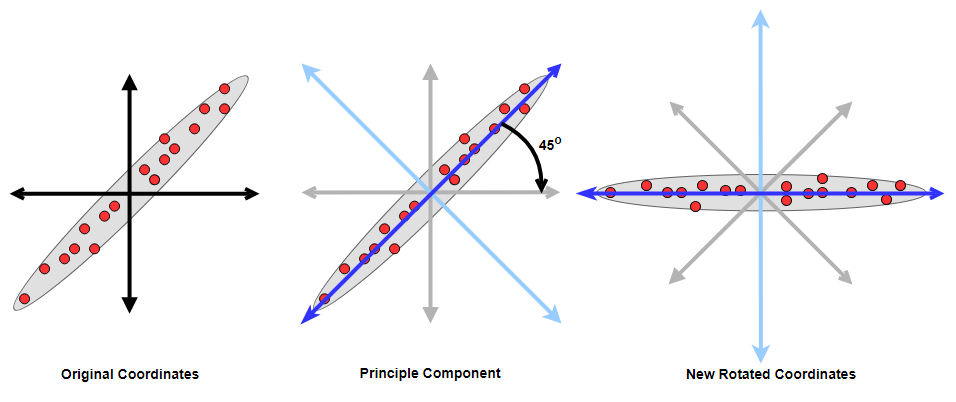

In [73]:
pca_model = PCA()

azdias_pca = pca_model.fit_transform(azdias_scaled)
customers_pca = pca_model.transform(customers_scaled)

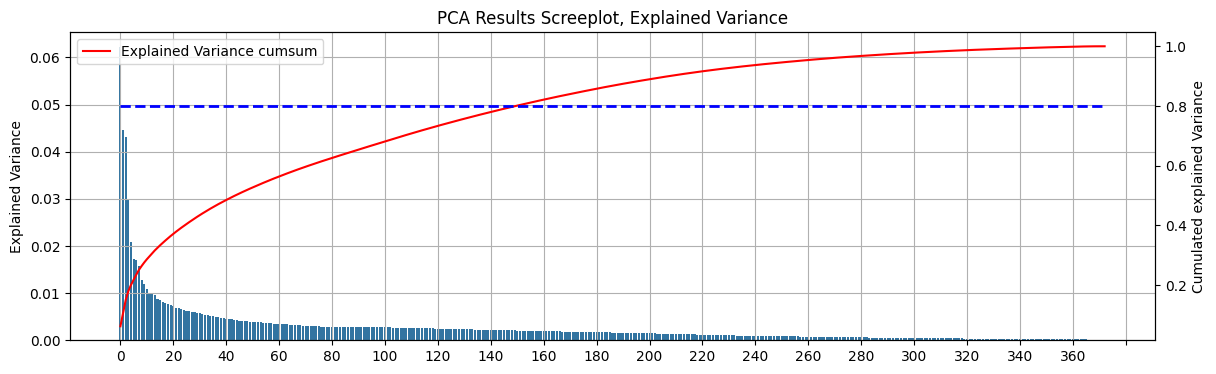

In [74]:
#investigate the variance accounted for by each principal components
num_of_comp = pca_model.explained_variance_ratio_.shape[0]
ind = np.arange(num_of_comp)
vals = pca_model.explained_variance_ratio_
cumulated_vals = np.cumsum(vals)

fig,sub = plt.subplots(1,1,figsize=(14,4))
sub_scd = sub.twinx()
sns.barplot(x = ind, y = vals, ax = sub)
sns.lineplot(x =  ind, y = cumulated_vals, ax = sub_scd, color = "red", label = "Explained Variance cumsum")
sub_scd.hlines(y = 0.8, xmin = np.min(ind), xmax = np.max(ind), color = "blue", lw=2, ls = "--")

sub.grid()
sub.set_title("PCA Results Screeplot, Explained Variance")
sub.set_ylabel("Explained Variance")
sub_scd.set_ylabel("Cumulated explained Variance")

sub.xaxis.set_major_locator(MultipleLocator(20))

As explained above, after having performed PCA on the data, the number of principal components to keep for the further process can be chosen for a desired proportion of explained variance of the original data.<br> 
For the task at hand, the threshold of explained variance is set to 80 %. Hence, the 151 principal components explain around 80 % of the variance of the original data.
So, the number of features has been reduced by ~ 200 features.

In [78]:
pca_model_final = PCA(n_components=0.8)

azdias_pca_final = pca_model_final.fit_transform(azdias_scaled)
customers_pca_final = pca_model_final.transform(customers_scaled)

explained_variance = pca_model_final.explained_variance_ratio_.sum()
print(f"Explained variance by PCA components: {explained_variance:.2%} with {pca_model_final.explained_variance_ratio_.shape[0]} components.")

Explained variance by PCA components: 80.13% with 151 components.


In [79]:
print('Shape of original azdias dataset: ',azdias.shape)
print('Shape of reduced azdias dataset: ',azdias_pca_final.shape)

print('Shape of original customers dataset: ',customers.shape)
print('Shape of reduced customers dataset: ',customers_pca_final.shape)

Shape of original azdias dataset:  (891221, 366)
Shape of reduced azdias dataset:  (817684, 151)
Shape of original customers dataset:  (191652, 369)
Shape of reduced customers dataset:  (145052, 151)


Interpretation of specific components

To get a sound understanding of the principal components determined by PCA, in the following section the first two component are analyzed and interpreted.<br>
Mathematically the principal components can be thought of as a linear combinations of the original features.
$$ PC_1 = 0.5 \cdot X_1 + 0.2 \cdot X_2 + 0.8 \cdot X_3$$ 
The coefficients of this linear combination are the so-called loadings of the respectice original features on the principal component. PCA loadings They help identify which variables contribute most to each of the Principal Components.
Mathematically, the their sums of squares within each component are the eigenvalues (components' variances) in the direction of the principal component (the eigenvector).

In [80]:
def calculate_component_composition(original_df, pca, dimension = 1):

    dimensions = ['Dimension_{}'.format(i) for i in range(1,len(pca.components_)+1)]

    components = pd.DataFrame(np.round(pca.components_, 4), columns = original_df.keys())
    components.index = dimensions

    components = components.T

    return components[f"Dimension_{dimension}"].sort_values(ascending=False)

def plot_component_composition(top_df, low_df, component_no):

    dim_components = pd.concat([top_df, low_df], axis = 0)

    fig, sub = plt.subplots(1, 1, figsize=(8,5))
    sns.barplot(orient = "h", y = dim_components.index, x = dim_components, ax = sub)
    sub.grid()
    sub.set_ylabel("")
    sub.set_xlabel("Loading")
    sub.set_title(f"Feature loadings on Component {component_no}")

* Interpretation of the first component

**Positive loadings**
* HH_EINKOMMEN_SCORE: estimated household_net_income 
* KBA13_ANTG3: number of 6-10 Family houses in the in PLZ / Region
* KBA13_BAUMAX: most common building types in PLZ
* KBA13_ANTG4: number of > 10 family houses in the PLZ
* EWDICHTE: density of inhabitants per km²
* ORTSGR_KL59: size of community
* FINANZHAUSBAUER: financial typology: main focus is the own house
* VK_DHT4A: not known
* D19_KONSUMTYP_MAX: consumption type 
* D19_GESAMT_DATUM: actuality of the last transaction with the complete file TOTAL

**Negative loadings**
* KONSUMNAEHE: distance from a building to PoS (Point of Sale)
* KBA05_ANHANG: share of trailers in the microcell
* KAB13_ANHANG: number of buildings in the microcell
* FINANZMINIMALIST: financial typology: low financial interest
* KBA13_AUTOQUOTE: share of cars per household within the PLZ8
* KBA05_ANTG1: number of 1-2 family houses in the cell
* KBA05_GBZ: number of buildings in the microcell
* KBA05_AUTOQUOT: share of cars per household
* MOBI_RASTER: not known, something with Mobility
* KBA13_ANTG1: number of 1-2 family houses in the PLZ8
-----------------
The first component seems to aggregate rather information of features which describe the sourrounding of the respective person such as the density of inhabitants per km² or the building types around the person's house.<br>
But also the net_income of his household, his consumption type or his tendency to own a house.

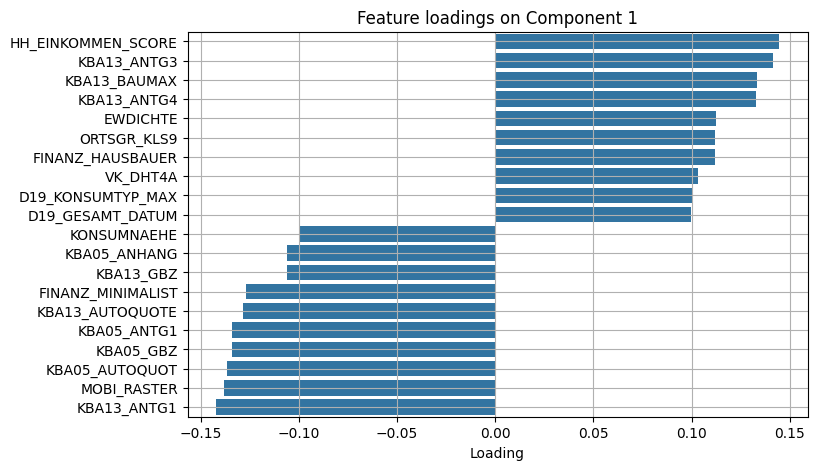

In [81]:
#Interpretation of the first component by looking at the top 10 loadings
top_10_dim_1 = calculate_component_composition(original_df=azdias_scaled, pca = pca_model_final, dimension= 1).head(10)
low_10_dim_1 = calculate_component_composition(original_df=azdias_scaled, pca = pca_model_final, dimension= 1).tail(10)

plot_component_composition(top_10_dim_1, low_10_dim_1, 1)

* Interpretation of the second component

**Positive Loadings** 
* FINANZ_ANLEGER: financial typology: investor
* FINANZ_SPARER: financial typology: money saver
* ONLINE_AFFINITAET: online affinity
* CJT_TYP_2: Advertising- and Consumptiontraditionalist
* youth_years_90: person has been raised in the 90s
* ALTERSKATEGORIE_FEIN: not known, deduction: age classification through another analysis
* RT_KEIN_ANREIZ: Not known
* SEMIO_PFLICHT: affinity indicating in what way the person is dutyfull traditional minded
* SEMIO_TRADV: affinity indicating in what way the person is traditional minded
* SEMIO_REL: affinity indicating in what way the person is religious

**Negative Loadings**
* CJT_KATALOGNUTZER: not known, deduction: if an individual purchases products in a catalog
* RETOURTYP_BK_S: return type for products
* KBA13_HERST_BMW_BENZ: share of BMW & Mercedes Benz within the PLZ8
* KOMBIALTER: not known, deduction: the combination of the age of the HH or the inner circle or the near environment of the person
* CJT_TYP_6: not known
* CJT_TYP_5: not known
* ALTERSKATEGORIE_GROB: age classification through prename analysis 
* CJT_TYP_4: not known
* FINANZ_VORSORGER: financial typology: be prepared
----------
The second principal component seems to aggregate one the one hand the financial focus of the (FINANZ_ANLEGER, FINANZ_SPARER) and the "conservativeness" of the person (SEMIO_PFLICHT, SEMIO_TRADV, SEMIO_REL), but <br>
contains also on the other hand certain information about the age of the individual (youth_years_90, ALTERSKATEGORIE_FEIN).

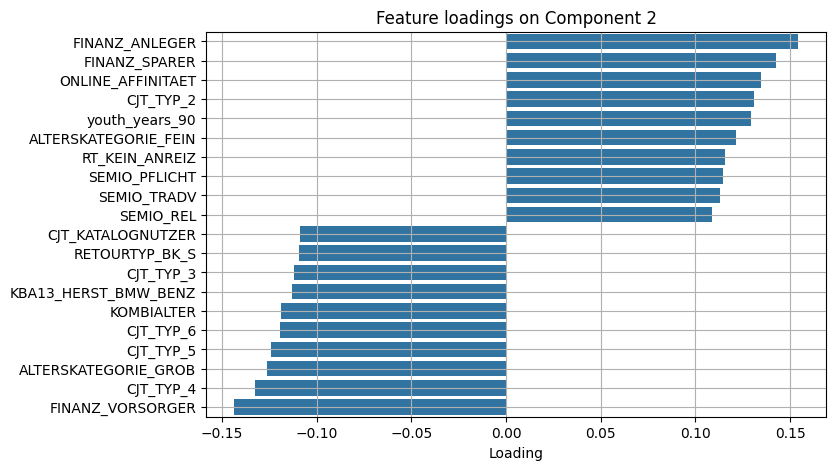

In [82]:
top_10_dim_2 = calculate_component_composition(original_df=azdias_scaled, pca = pca_model_final, dimension= 2).head(10)
low_10_dim_2 = calculate_component_composition(original_df=azdias_scaled, pca = pca_model_final, dimension= 2).tail(10)

plot_component_composition(top_10_dim_2, low_10_dim_2, 2)

## IV. Clustering

A concrete goal of the company is to learn more and even identify its main customers and use these information as a solid basis for a strategy for marketing campaigns.
Therefore in this section, the azdias (demographic dataset of Germany) is clustered in certain groups in order apply these clustering method also on the customers data of the company (customers dataset).<br>

We apply the K-Means Clustering algorithm for this task because of its scalability on bigger datasets (such as the azdias dataset), but especially because of its simplicity. 

Apply Clustering to the General Population

First of all a list of 14 possible clusters is established in order to run the K-Means algorithm 14 times and choose after the training the best performing model with the help of the elbow-method.

In [90]:
cluster_no = list(range(3,30,2))
scores = []

for k in cluster_no:

    print(f"----------RUN k={k} Clustering----------")
    # run k-means clustering on the data and...
    model = KMeans(n_clusters=k, n_init="auto", random_state=47)
    model.fit(azdias_pca_final)

    # compute the average within-cluster distances.
    score = np.abs(model.score(azdias_pca_final))
    print(f"Score: {score}")
    scores.append(score)

----------RUN k=3 Clustering----------
Score: 224311821.87967813
----------RUN k=5 Clustering----------
Score: 215344413.92743415
----------RUN k=7 Clustering----------
Score: 210243627.98027325
----------RUN k=9 Clustering----------
Score: 206754998.17705175
----------RUN k=11 Clustering----------
Score: 204244736.97796497
----------RUN k=13 Clustering----------
Score: 202135129.38925755
----------RUN k=15 Clustering----------
Score: 200188722.8974956
----------RUN k=17 Clustering----------
Score: 198722670.78256696
----------RUN k=19 Clustering----------
Score: 197163487.5659244
----------RUN k=21 Clustering----------
Score: 194850329.2356246
----------RUN k=23 Clustering----------
Score: 192943650.6241155
----------RUN k=25 Clustering----------
Score: 191427879.99478355
----------RUN k=27 Clustering----------
Score: 190112534.75395143
----------RUN k=29 Clustering----------
Score: 188237741.27726892


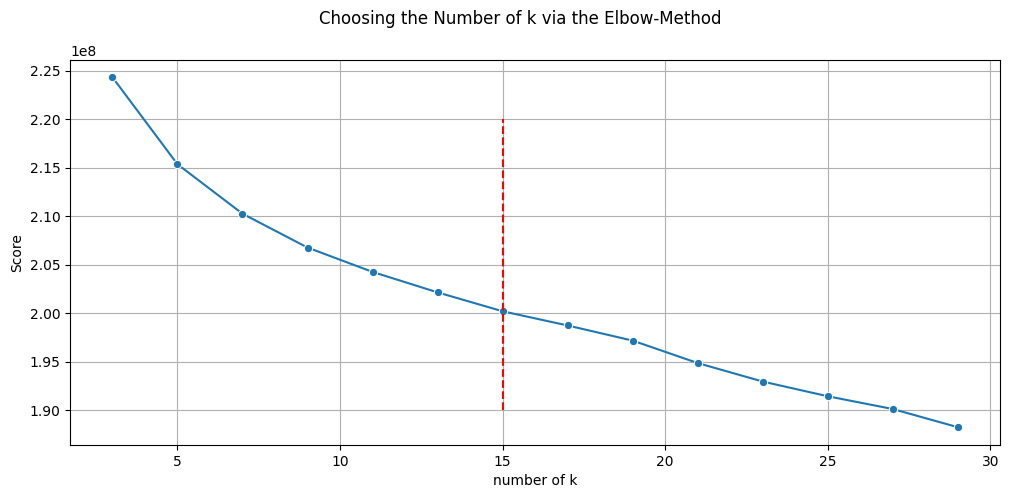

In [114]:
fig, sub = plt.subplots(1, 1, figsize=(12,5))

sns.lineplot(x = cluster_no, y = scores, ax = sub, marker = "o")
sub.set_xlabel("number of k")
sub.set_ylabel("Score")
sub.grid(True)

sub.vlines(x = 15, ymin = 1.9 * 10**8, ymax = 2.2*10**8, ls="--", color = "red")

fig.suptitle("Choosing the Number of k via the Elbow-Method");

To choose a number of cluster, the elbow method can be applied.
The plot above shows the Score of respective the k-means models over its number of k-clusters. The score is the "within cluster of sum of squares"-value which is also called inertia.
It describes how coherent / near the different data points within the clusters are to each other / the cluster center.

$$
Inertia:
\sum_{i=1}^{N} (x_{i} - C_{k})²
$$

We choose with the elbow method, the number of k-cluster where the rate of inertia reduction of the "inertia-function" gets significantly lower over the clusters. 
In this cases the plot above shows a kind of "Elbow" and this number of cluster can be chosen. 
Above there is not really an evident "elbow", but the inertia is at k=15 significantly reduced in relation to k=3 and moreover the reduction rate is slowing (subjectively) a bit down.

In [115]:
opt_k = 15
model = KMeans(n_clusters=opt_k, n_init="auto")
model.fit(azdias_pca_final)

KMeans(n_clusters=15)

In [116]:
cluster_assignment_azdias = model.predict(azdias_pca_final)

Apply Clustering to the customers dataset

Now after having trained the k-means cluster model on the azdias dataset, we apply these gained information on the demographic dataset on the customers dataset of the company.<br>
If the normalized distribution of the clusters on the whole customers dataset would be exactly the same as in the demographics dataset, it can be deducted that there is no cluster of individuals which is significantly more represented in the customers base of the company compared to the whole population. 
So, vice versa if there are clusters of individuals which are remarkably overrepresented in the customer database, these individuals embody the current main customer base. 

In [123]:
cluster_assignment_customer = model.predict(customers_pca_final)

In [124]:
azdias_scaled["cluster_assignment"] = cluster_assignment_azdias.copy()
customers_scaled["cluster_assignment"] = cluster_assignment_customer.copy()

Compare the customers dataset to the azdias demographic dataset

In this part, the customers and the azdias dataset are compared to find out, if its possible to identify a certain customer type of the company.

In [125]:
cluster_assignment_population_ = pd.DataFrame({"cluster_assignment_population": cluster_assignment_azdias})
cluster_assignment_customer_ = pd.DataFrame({"cluster_assignment_customer": cluster_assignment_customer})

cluster_analysis = pd.concat([
np.round(cluster_assignment_customer_.value_counts(normalize=True).sort_index().rename("cluster_assignment_customer"),2),
np.round(cluster_assignment_population_.value_counts(normalize=True).sort_index().rename("cluster_assignment_population"),2)], axis =1).reset_index().rename({"level_0": "cluster"}, axis = 1)

In [126]:
cluster_analysis

,cluster,cluster_assignment_customer,cluster_assignment_population
0,0,0.02,0.05
1,1,0.02,0.04
2,2,0.12,0.09
3,3,0.01,0.10
4,4,0.01,0.09
5,5,0.00,0.04
6,6,0.11,0.05
7,7,0.28,0.07
8,8,0.03,0.08
9,9,0.12,0.08


In [127]:
cluster_analysis_ = pd.melt(
    frame = cluster_analysis,
    id_vars=["cluster"],
    value_vars=["cluster_assignment_customer", "cluster_assignment_population"],
    var_name = "category",
    value_name="proportion"
)

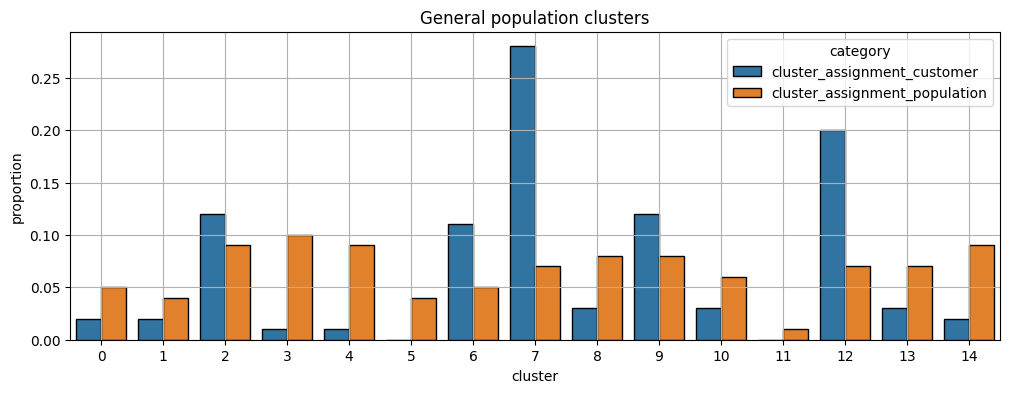

In [128]:
fig, sub = plt.subplots(1,1,figsize=(12,4))
sns.barplot(data = cluster_analysis_, x = "cluster", y = "proportion", hue = "category", ax = sub, edgecolor = "black")

sub.set_title("General population clusters")
sub.grid()

The plot above shows the percentage of each respective cluster of the whole dataset over the respective clusters.<br>
The cluster 2, 6, 7, 9 and the cluster 12 are significantly overrepresented compared to the azdias dataset whereas cluster 7 and 12 stand out.
Therefore these clusters can be considered to be the main customer base of the company.<br>

Cluster 3, 4, 5, 13 and 14 are significantly underrepresented. 
It can be pointed out that there is no cluster which shows the exact same proportion compared to the azdias dataset.

Check overrepresented Clusters

In [145]:
centroid_7 = scaler.inverse_transform(X = pca_model_final.inverse_transform(model.cluster_centers_[6]).reshape(1, -1))
centroid_12 = scaler.inverse_transform(X = pca_model_final.inverse_transform(model.cluster_centers_[11]).reshape(1, -1))

In [146]:
centroid_7 = pd.DataFrame(centroid_7, columns = customers_copy.columns).T.rename({0: "value_cluster_7"}, axis = 1)
centroid_12 = pd.DataFrame(centroid_12, columns = customers_copy.columns).T.rename({0: "value_cluster_12"}, axis = 1)

cluster_comparison = pd.merge(
    centroid_7,
    centroid_12,
    left_index=True,
    right_index=True
)

In [157]:
relevant_feats_for_desc = ["ANZ_PERSONEN", "ALTER_HH", "ANZ_HH_TITEL", "ANZ_KINDER", "BALLRAUM", 
                           "HH_EINKOMMEN_SCORE", "FINANZTYP", "GEBAEUDETYP", "SEMIO_REL", "SEMIO_FAM",
                           "SEMIO_KRIT", "SEMIO_KULT", "SEMIO_MAT", "SEMIO_RAT"]

cluster_comparison.loc[relevant_feats_for_desc]

,value_cluster_7,value_cluster_12
ANZ_PERSONEN,1.816652,3.786095
ALTER_HH,11.122798,15.999938
ANZ_HH_TITEL,0.092051,0.066144
ANZ_KINDER,0.172872,0.300509
BALLRAUM,2.956964,4.635127
HH_EINKOMMEN_SCORE,3.197986,3.288157
FINANZTYP,4.040127,3.317937
GEBAEUDETYP,3.141665,2.929691
SEMIO_REL,3.570750,4.942849
SEMIO_FAM,3.927270,4.595093


* ANZ_PERSONEN: number of adult persons in the household
* ALTER_HH: main age within the household (11: 1945 - 1949, 15: 1965-1969)
* ANZ_HH_TITEL: number of academic title holder in building
* ANZ_KINDER: number of children in the household
* BALLRAUM: distance to next urban centre (3: 20-30 km, 4-5: 30-50 km)
* HH_EINKOMMEN_SCORE: estimated household net income (3: high income, 4: average income)
* FINANZTYP: best describing financial type for the person (3: main focus is the own house, 4: be prepared)
* GEBAEUDETYP: type of building (residential or commercial) (3: mixed (=residential and company) building)
* SEMIO_REL: affinity indicating in what way the person is religious (3: high affinity, 5: low affinity)
* SEMIO_FAM: affinity indicating in what way the person is familiar minded (4: average affinity, 5: low affinity)
* SEMIO_KRIT: affinity indicating in what way the person is critical minded (3: high affinity, 4: average affinity)
* SEMIO_KULT: affinity indicating in what way the person is cultural minded (3: high affinity, 4: average affinity)
* SEMIO_MAT:  affinity indicating in what way the person is material minded (3: high affinity, 4: average affinity)
* SEMIO_RAT: affinity indicating in what way the person is of a rational mind (3: high affinity, 4: average affinity)

To analyze the overrepresented cluster 7 and 12, the cluster centroids values for the Components can be inverse_transformed to the "original" values.
Looking above onto a reduced view into the comparison between the two clusters,
* the cluster 7 seems to embody individuals of advanced age (~ > 70 years old), living with around 2 persons in a rural area (around 20-30 km from the next city) without children, but earning a high income focusing concerning the financial perspective to be prepared for the future. Moreover the individuals belonging to this cluster are average religious, average family persons, average cultural minded, less critical minded, average material minded and average rational minded

* the cluster 12 seems to embody individuals of mid age (~ 55), living with around 4 persons in a very rural area (around 30-50 km from the next city) without children, earning a high income focusing on owning an own house. The individuals belonging to this cluster have a low affinity to religion, a low affinity to family, an average to high affinity to critical thinking, a low affinity cultural topics, an average affinity to materialism and not really rational minded

## V. Conclusion

A client, a Mail-Order Company selling organic products, of Arvato wants to be advised concerning a more efficient way to acquire new clients.
The present analysis focuses on the customer segmentation based on the customer database of the client and a demographic dataset of the german population in order to provide more transparency concerning the customer of the company.<br>

The datasets, the customers dataset originally from the database of the comapny and the demographic dataset of Germany, describe in each row of the respective dataset an individual along a high number of features such as Age, number of person living in the same household, financial focus and many more. 

The goal of the analysis is to use Principal Component Analysis to reduce the high dimension-dataset without loosing too much information and in the further steps to cluster the customers along these principal components (without falling for the curse of dimensionality) in order to find out the main customer base for the mail-order company.

First of all general data preparation steps are performed (missing value handling, dropping irrelevant columns, dropping highly correlated columns, imputing missing values, feature encoding, standardization).
Then PCA is performed on the prepared demographic data and the trained model is applied on the customers dataset. The result (the principal components) are then analyzed and interpreted. 
As a final step, K-Means Algorithm is leveraged to cluster the prepared demographic dataset and the model is again applied on the customers dataset in order to find the cluster as well in this dataset. 
The datasets are clustered in k=15 clusters. Comparing the demographic dataset and the customers dataset two clusters 7 and cluster 15 stand out as particularly relevant for the mail-order company.

The analysis provide a detailed view on the customer base and the company could push the analysis even further and examine the underrepresented clusters in order to get a grasp which customer groups could even be strategic individual circles to develop in.

<img src="../data/img/analysis_img.PNG" width="500px" alt="Analysis Image"/>
